In [1]:
%config Completer.use_jedi = False 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Dict, Tuple
from evaluation_utils.evaluation_utils import map_dict_values

In [3]:
import sys
sys.path.append('..')

In [4]:
print(sys.path)

['/home/flo/Workspace/Uni/Masterarbeit/simulation/visualization', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/flo/Workspace/Uni/Masterarbeit/mosaikvenv/lib/python3.8/site-packages', '/home/flo/Workspace/Uni/Masterarbeit/simulation', '/home/flo/Workspace/Uni/Masterarbeit/simulation/batterysim', '/home/flo/Workspace/Uni/Masterarbeit/simulation/householdsim', '/home/flo/Workspace/Uni/Masterarbeit/mosaikvenv/lib/python3.8/site-packages/IPython/extensions', '/home/flo/.ipython', '..']


In [5]:

from evaluation_utils.hdf5_to_df import convert_hdf5_to_viewdict

from evaluation_utils.pricing import *

In [6]:
from pathlib import PurePath
#simulation_directory = PurePath("../data/sim_results/htw_berlin_complete/")
simulation_directory = PurePath("../data/results_32_32/")

sim_name = "from_2010-01-01_to_2010-12-29_ConProPV_(32, 32, 0)_%s.hdf5"
def create_sim_file_name(specifier):
    return PurePath(simulation_directory, sim_name % specifier)
# import os 
# os.listdir(simulation_directory)

In [7]:
figure_folder = PurePath("figures/htw_berlin_32_32")

# Wirtschaftlichkeit Vergleichen
## Arten des Stromhandels
Vergleiche Stromkosten der Prosumenten und Konsumenten
- Kein PV
- PV ohne enerDAG
- PV + Batterie ohne enerDAG
- enerDAG ohne Batterie
- enerDAG mit SimpleBattery
- enerDAG mit SmartBattery (SARIMA Modell)


In [8]:
prices = PriceSpec(
            Money(int(714 * Money.FRACTION_MULTIPLIER / 100) ),
            Money(int(31 * Money.FRACTION_MULTIPLIER)),
            cost_of_generation=Money(6 * Money.FRACTION_MULTIPLIER ),
            cost_of_storage=Money((int) (55 * Money.FRACTION_MULTIPLIER / 10)),
            enerdag_net_costs=Money.from_cents(5),
            avg_p2p_trade=Money.from_cents(19),)

KEY_NO_BATTERY = "No Battery"
KEY_SIMPLE_10_kWh = "Simple Battery (10 kWh)"
KEY_SIMPLE_5_kWh = "Simple Battery (5 kWh)"
KEY_SARIMA_SMART_10kWh  = "SARIMA Smart Battery (10 kWh)"
KEY_PERFECT_SMART_10kWh = "Perfect SmartBattery (10 kWh)"
KEY_SARIMA_SMART_5kWh = "SARIMA SmartBattery (5 kWh)"
KEY_PERFECT_SMART_5kWh = "Perfect SmartBattery (5 kWh)"

simulation_file_paths =  {
    KEY_NO_BATTERY: create_sim_file_name("NoBattery_0Wh"),
    KEY_SIMPLE_10_kWh: create_sim_file_name("SimpleBattery_10000Wh"),
    KEY_SARIMA_SMART_10kWh: create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_10000Wh"),
    KEY_SIMPLE_5_kWh: create_sim_file_name("SimpleBattery_5000Wh"),
    KEY_SARIMA_SMART_5kWh: create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_5000Wh"),
    KEY_PERFECT_SMART_5kWh: create_sim_file_name("CSV_perfect_SmartBattery_5000Wh"),
    KEY_PERFECT_SMART_10kWh: create_sim_file_name("CSV_perfect_SmartBattery_10000Wh"),
}

def create_new_dict_with_function(d, func):
    new_d = dict()
    for sim in d:
        new_d[sim] = func(d[sim])
    return new_d

def create_dataframe_dict(path_dict):
    return create_new_dict_with_function(path_dict, lambda x: convert_hdf5_to_viewdict( h5py.File(x, "r")))
  


simulation_dataframes = map_dict_values(simulation_file_paths, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))

simulation_costs = map_dict_values(simulation_dataframes, lambda x: dict([(name, household_power_cost(df, prices)) for (name, df) in x.items()]))


In [9]:
def eid_to_label(eid: str) -> str:
    if "pid" in eid:
        pid = int(eid.split("pid")[1][0])
        return "Prosument %d" % (pid, )
    else: 
        return eid.split(".")[-1]
def print_model_costs(prices: Dict[str, List[Tuple[str, float]]]):
    for model, model_prices in prices.items():
        print("%s: %.2f" % (model, sum(map(lambda x: x[1], model_prices))))
        for pid, price in model_prices:
            print("\t%s: %.2f" % (eid_to_label(pid), price))
    
def tex_model_costs(prices: Dict[str, List[Tuple[str, float]]]):
    s = ""
    for model, model_prices in prices.items():
        s =  "%s%s" % (s, model ,)
        total =  sum(map(lambda x: x[1], model_prices))
        
        s = ("%s & \\myEUR{%.2f}" % (s, total)).replace(".", ",")
        s = ("%s  \\\\ %s" % (s, os.linesep))
    
    return s


In [10]:
def construct_cost_info_string(d):
    s = ""
    for sim in d:
        s += sim + os.linesep
        for eid, stats in d[sim].items():
            s += eid_to_label(eid) + os.linesep
            s += str(stats) + os.linesep
    return s


In [11]:
def calc_buy_cost(energy_stats: HouseholdEnergyStats, price_spec: PriceSpec):
    """ 
    Calculate the Cost when someone buys all the consumed energy from the utility provider
    """
    return (energy_stats.total_energy.total_energy * price_spec.cost_buy_from_grid.to_euro()) / 1000

def filter_prosumers_and_apply_func(func, energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))
    return [(name, func(stats, prices)) for (name,stats) in prosumers.items()]

def cal_buy_cost_for_prosumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_prosumers_and_apply_func(calc_buy_cost, energy_stats, prices)

def calc_pv_wo_enerdag(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))    
    return [(name, calc_costs_pv_wo_enerdag(stats, prices).to_euro()) for (name, stats) in prosumers.items()]


def calc_pv_and_batter_wo_enerdag(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))    
    return [(name, calc_costs_pv_and_battery_wo_enerdag(stats, prices).to_euro()) for (name,stats) in prosumers.items()]

def calc_enerdag_total_cost(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))    
    return [(name, household_power_cost(stats, prices).total_energy.total_money.to_euro()) for (name,stats) in prosumers.items()]


from typing import Iterable, Callable


def create_plot_data(spec: Iterable[Tuple[str, str, Callable]], source: Dict) -> Dict[str, pd.DataFrame]:
    d = dict()
    for (name, selector, creator) in spec:
        d[name] = creator(source[selector])
    return d
    
NO_PV = "No PV"
PV_AND_BATT_10kWh = "PV + Battery (10kWh) w/o enerDAG"
PV_AND_BATT_5kWh = "PV + Battery (5kWh) w/o enerDAG"
PV_WO_ENERDAG = "PV w/o enerDAG"
ENERDAG_WO_BATT = "enerDAG w/o battery"
ENERDAG_WITH_10kWh_SIMPLE = "enerDAG Simple Battery (10 kWh)"
ENERDAG_WITH_5kWh_SIMPLE = "enerDAG Simple Battery (5 kWh)"
ENERDAG_WITH_10kWh_SMART = "enerDAG Smart Battery (10 kWh)"
ENERDAG_WITH_5kWh_SMART = "enerDAG Smart Battery (SARIMA, 5 kWh)"
ENERDAG_WITH_5kWh_SMART_PERFECT = "enerDAG Smart Battery (Perfect, 5 kWh)"



plot_data_prosumers = {
    # NO_PV:  cal_buy_cost_for_prosumers(simulation_costs[KEY_NO_BATTERY], prices), 
    PV_WO_ENERDAG: calc_pv_wo_enerdag(simulation_dataframes[KEY_NO_BATTERY], prices), 
    ENERDAG_WO_BATT: calc_enerdag_total_cost(simulation_dataframes[KEY_NO_BATTERY], prices),
    PV_AND_BATT_10kWh: calc_pv_and_batter_wo_enerdag(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WITH_10kWh_SIMPLE: calc_enerdag_total_cost(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WITH_10kWh_SMART: calc_enerdag_total_cost(simulation_dataframes[KEY_SARIMA_SMART_10kWh], prices), 
    PV_AND_BATT_5kWh: calc_pv_and_batter_wo_enerdag(simulation_dataframes[KEY_SIMPLE_5_kWh], prices), 
    ENERDAG_WITH_5kWh_SIMPLE: calc_enerdag_total_cost(simulation_dataframes[KEY_SIMPLE_5_kWh], prices), 
    ENERDAG_WITH_5kWh_SMART: calc_enerdag_total_cost(simulation_dataframes[KEY_SARIMA_SMART_5kWh], prices), 
    ENERDAG_WITH_5kWh_SMART_PERFECT: calc_enerdag_total_cost(simulation_dataframes[KEY_PERFECT_SMART_5kWh], prices),
}

In [12]:
def create_normal_bar_chart(ax, plot_data, colors):
    bar_x_coordinates = []
    bar_height = []
    bar_color = []
    tick_labels = []
    legend = None
  

    for x_index, (configuration, costs) in enumerate(plot_data.items()):

        legend = []
        total_costs = sum(map(lambda x: x[1], costs))
        bar_height.append(total_costs)
        bar_color.append(colors[x_index % len(colors)])
        tick_labels.append(configuration)
        bar_x_coordinates.append(x_index)
    ax.bar(x=bar_x_coordinates, 
                height=bar_height, 
                tick_label=tick_labels,
                bottom=0,
                color=bar_color)
        
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_ylabel("€")
    return legend


def print_costs(plot_data): 
 for  (configuration, costs) in plot_data.items():

        
        print(configuration)
        total = 0
        for cost in costs:
            household_name = eid_to_label(cost[0])
            cost_household = cost[1]
            print("\t%s: %.2f" % (household_name, cost_household))
        total  = sum(list(map(lambda x: x[1], costs)))
        print("\ttotal: %.2f" % ( total, ))

def get_min_max_costs(plot_data): 
    min_costs = np.float64("inf")
    max_costs = np.float64("-inf")

    max_config, max_households  = (None, None)
    min_config, min_households  = (None, None)
    for  (configuration, costs) in plot_data.items():

        total  = sum(list(map(lambda x: x[1], costs)))
        if total > max_costs:
            max_costs = total
            max_config = configuration
            max_households = costs
        if total < min_costs:
            min_costs = total
            min_config = configuration
            min_households = costs
        
    print("Max: %s: %.2f" % (max_config, max_costs) )
    
    print("Min: %s: %.2f" % (min_config, min_costs) )

    
            


In [13]:
for key, val in plot_data_prosumers.items():
    print(key, len(val))

PV w/o enerDAG 32
enerDAG w/o battery 32
PV + Battery (10kWh) w/o enerDAG 32
enerDAG Simple Battery (10 kWh) 32
enerDAG Smart Battery (10 kWh) 32
PV + Battery (5kWh) w/o enerDAG 32
enerDAG Simple Battery (5 kWh) 32
enerDAG Smart Battery (SARIMA, 5 kWh) 32
enerDAG Smart Battery (Perfect, 5 kWh) 32


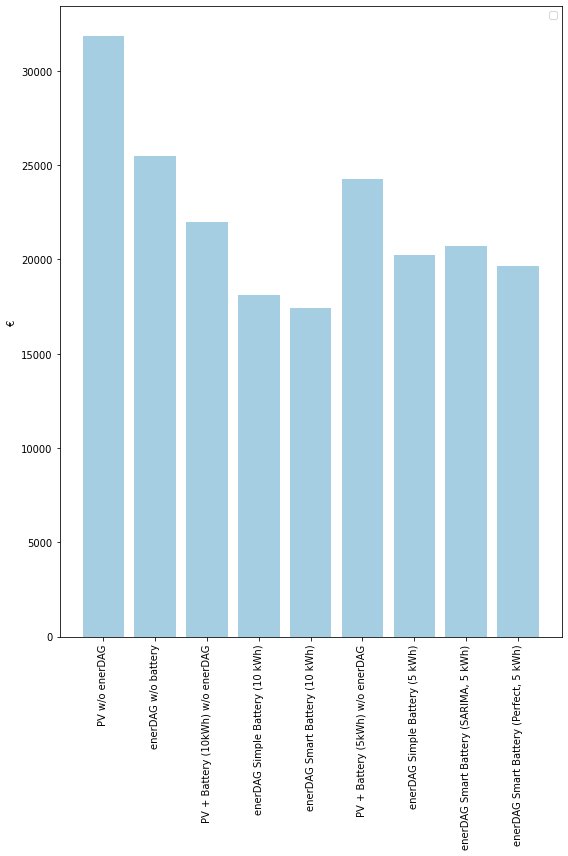

In [14]:
fig, ax = plt.subplots(figsize=(8,12))

# https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=4
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']

market_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']


legend = create_normal_bar_chart(ax, plot_data_prosumers, colors=colors[:1])
ax.legend(legend)
# print_costs(plot_data_prosumers)
# get_min_max_costs(plot_data_prosumers)
fig.tight_layout()
fig.savefig(PurePath(figure_folder, "economic_comparison_neighborhood_configs.png"))


In [15]:
print(tex_model_costs(plot_data_prosumers))

PV w/o enerDAG & \myEUR{31823,57}  \\ 
enerDAG w/o battery & \myEUR{25464,73}  \\ 
PV + Battery (10kWh) w/o enerDAG & \myEUR{21978,70}  \\ 
enerDAG Simple Battery (10 kWh) & \myEUR{18099,47}  \\ 
enerDAG Smart Battery (10 kWh) & \myEUR{17423,94}  \\ 
PV + Battery (5kWh) w/o enerDAG & \myEUR{24288,41}  \\ 
enerDAG Simple Battery (5 kWh) & \myEUR{20213,99}  \\ 
enerDAG Smart Battery (SARIMA, 5 kWh) & \myEUR{20700,86}  \\ 
enerDAG Smart Battery (Perfect, 5 kWh) & \myEUR{19663,79}  \\ 



In [16]:
min_cost, min_scenario, max_cost, max_scenario = (10e6, None, -10e6, None)
for scenario, prosumer_costs in plot_data_prosumers.items():
    scenario_cost = sum(map(lambda x: x[1], prosumer_costs))
    print(scenario, scenario_cost)
    min_cost = min(min_cost, scenario_cost)
    max_cost = max(max_cost, scenario_cost)
    if scenario_cost == max_cost:
        max_scenario = scenario
    if scenario_cost == min_cost:
        min_scenario = scenario

print(min_cost, min_scenario)
print(max_cost, max_scenario)
print(max_cost - min_cost)
print((max_cost - min_cost)/32)

PV w/o enerDAG 31823.570000000003
enerDAG w/o battery 25464.730000000003
PV + Battery (10kWh) w/o enerDAG 21978.7
enerDAG Simple Battery (10 kWh) 18099.47
enerDAG Smart Battery (10 kWh) 17423.94
PV + Battery (5kWh) w/o enerDAG 24288.41
enerDAG Simple Battery (5 kWh) 20213.98999999999
enerDAG Smart Battery (SARIMA, 5 kWh) 20700.86
enerDAG Smart Battery (Perfect, 5 kWh) 19663.79
17423.94 enerDAG Smart Battery (10 kWh)
31823.570000000003 PV w/o enerDAG
14399.630000000005
449.98843750000015


In [17]:
prosumer_simple = 18099.47
prosuner_smart = 17423.94 
diff_prosumer_simple_smart = prosumer_simple - prosuner_smart
diff_prosumer_simple_smart

675.5300000000025

In [18]:
diff_prosumer_simple_smart / 32

21.110312500000077

## Vergleiche die Vorhersagemodelle bei enerDAG mit SmartBattery 
Stromkosten von SmartBattery bei verschiedenen Vorhersagemodellen
- SARIMA
- B24
- Perfect
    

In [19]:
def sarima_model_str(ar, i, ma, p, q, d) -> str:
    return "CSV_(%d, %d, %d)_(%d, %d, %d, 24)_history_4_SmartBattery_10000Wh" %(ar, i, ma, p, q,d)

MODEL_PERFECT = "Perfect"
MODEL_B24 = "B24"
MODEL_SARIMA_101 = "$(1,0,1)\\times (1,0,1)24$"
MODEL_SARIMA_200 = "$(1,0,1)\\times (2,0,0)24$"

simulation_files_model_comparison =  {
    MODEL_PERFECT: create_sim_file_name('CSV_perfect_SmartBattery_10000Wh'), 
    MODEL_B24: create_sim_file_name('CSV_backschift_24h_SmartBattery_10000Wh'),
    MODEL_SARIMA_101: create_sim_file_name(sarima_model_str(1,0,1,1,0,1)),
    MODEL_SARIMA_200: create_sim_file_name(sarima_model_str(1,0,1,2,0,0)), 
}



simulation_dataframes_model_comparison = map_dict_values(simulation_files_model_comparison, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))

sim_hh_costs_model_comparison = map_dict_values(simulation_dataframes_model_comparison, lambda x: dict([(name, household_power_cost(df, prices)) for (name, df) in x.items()]))

plot_data_model_comparison = dict()
for sim in simulation_dataframes_model_comparison:
    plot_data_model_comparison[sim] = calc_enerdag_total_cost(simulation_dataframes_model_comparison[sim], prices)


Max: $(1,0,1)\times (2,0,0)24$: 17423.94
Min: Perfect: 16624.48


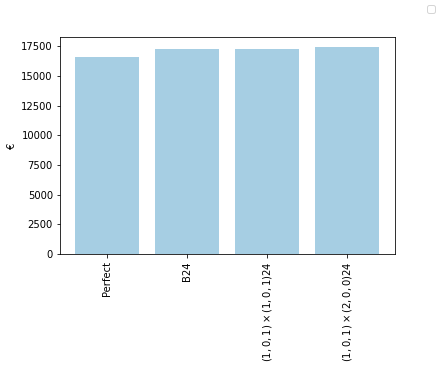

In [20]:
fig, ax = plt.subplots()
legend = create_normal_bar_chart(ax, plot_data_model_comparison, colors=colors[:1])
# print_costs(plot_data_model_comparison)
get_min_max_costs(plot_data_model_comparison)

fig.legend(legend);
fig.savefig(PurePath(figure_folder, "economic_comparisons_models.png"))


In [21]:

plot_data_model_comparison.keys()

dict_keys(['Perfect', 'B24', '$(1,0,1)\\times (1,0,1)24$', '$(1,0,1)\\times (2,0,0)24$'])

In [22]:
# Ausgabe ist zum erstellen einer tex tabelle da.
# print(tex_model_costs(plot_data_model_comparison))

In [23]:
# print(construct_cost_info_string(sim_hh_costs_model_comparison))

In [24]:
def create_diff_data(data: Dict[str, List[Tuple[str, float]]], base_key) -> Dict[str, List[Tuple[str, float]]]:
    base = data[base_key]
    new_data = dict()
    for key in data:
        if key == base_key:
            continue
        model_result = [(base_key if base_key == model_key else "keys dont match", model_val - base_val) 
                            for (base_key, base_val), (model_key, model_val) in zip(base, data[key])]
        

        new_data[key] = model_result
    return new_data

model_comparison_diff = create_diff_data(plot_data_model_comparison, MODEL_PERFECT)


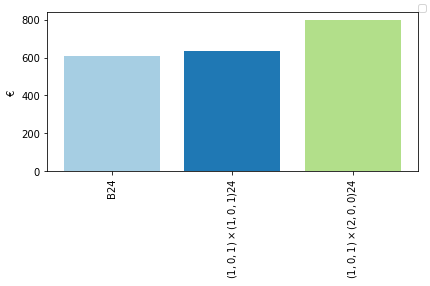

In [25]:

fig, ax = plt.subplots()
legend = create_normal_bar_chart(ax, model_comparison_diff, colors=colors)

fig.legend(legend);
fig.tight_layout()
fig.savefig(PurePath(figure_folder, "economic_comparisons_models_difference.png"))

In [26]:
scenario_diff_plot_data = plot_data_model_comparison
scenario_diff_plot_data[ENERDAG_WITH_10kWh_SIMPLE] = plot_data_prosumers[ENERDAG_WITH_10kWh_SIMPLE]
scenario_comp_diff = create_diff_data(scenario_diff_plot_data, ENERDAG_WITH_10kWh_SIMPLE)


Max: $(1,0,1)\times (2,0,0)24$: -675.53
Min: Perfect: -1474.99


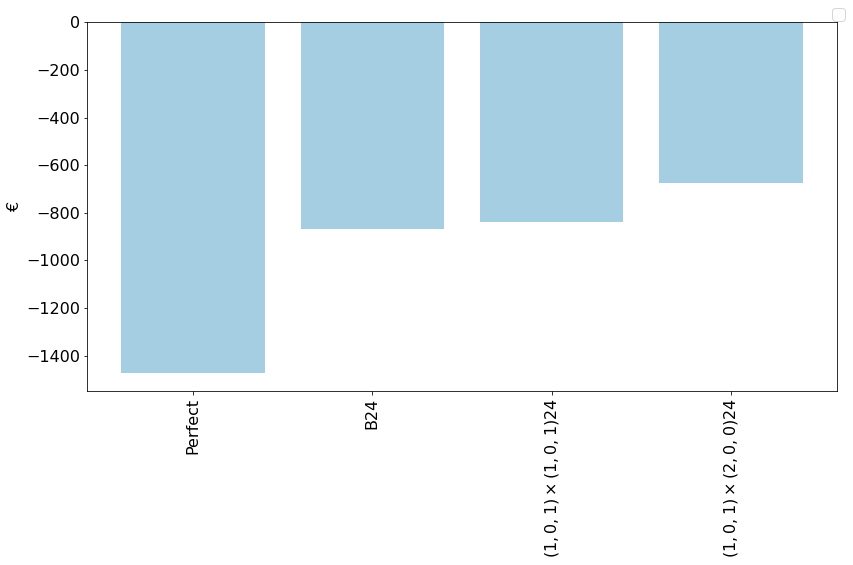

In [27]:

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(12,8))
legend = create_normal_bar_chart(ax, scenario_comp_diff, colors=colors[:1])

get_min_max_costs(scenario_comp_diff)

fig.legend(legend);
fig.tight_layout()
fig.savefig(PurePath(figure_folder, "economic_comparisons_smart_simple_battery.png"))


In [28]:
fig.get_size_inches() * 1.5

array([18., 12.])

# Für Konsumenten: 


In [29]:
def consumer_calc_buy_cost(energy_stats: HouseholdEnergyStats, price_spec: PriceSpec):
    """ 
    Calculate the Cost when someone buys all the consumed energy from the utility provider
    """
    return (energy_stats.total_energy.total_energy * price_spec.cost_buy_from_grid.to_euro()) / 1000

def filter_consumers_and_apply_func(func, energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "consumer" in x[0], list(energy_stats.items()))))
    return [(name, func(stats, prices)) for (name,stats) in prosumers.items()]

def cal_buy_cost_for_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda x,y : consumer_calc_buy_cost(x,y), energy_stats, prices)

def calc_pv_wo_enerdag_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda x,y: calc_costs_pv_wo_enerdag(x,y).to_euro(), energy_stats, prices)
    


def calc_pv_and_batter_wo_enerdag_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda x,y: calc_costs_pv_and_battery_wo_enerdag(x,y).to_euro(), energy_stats, prices)
    
def calc_enerdag_total_cost_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda stats, prices: household_power_cost(stats, prices).total_energy.total_money.to_euro(), energy_stats, prices)


In [30]:
simulation_dataframes.keys()

dict_keys(['No Battery', 'Simple Battery (10 kWh)', 'SARIMA Smart Battery (10 kWh)', 'Simple Battery (5 kWh)', 'SARIMA SmartBattery (5 kWh)', 'Perfect SmartBattery (5 kWh)', 'Perfect SmartBattery (10 kWh)'])

In [31]:

plot_data_consumers = {
    PV_AND_BATT_10kWh: calc_pv_and_batter_wo_enerdag_consumers(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WO_BATT: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_NO_BATTERY], prices),
    ENERDAG_WITH_10kWh_SIMPLE: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WITH_10kWh_SMART: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SARIMA_SMART_10kWh], prices), 
}
    

Max: PV + Battery (10kWh) w/o enerDAG: 43583.14
Min: enerDAG Smart Battery (10 kWh): 39697.07


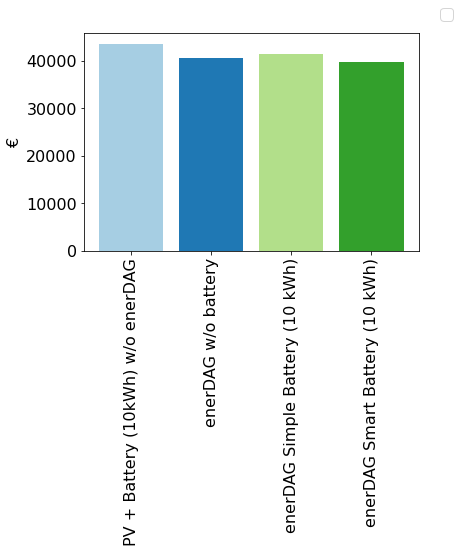

In [32]:
fig, ax = plt.subplots()
legend = create_normal_bar_chart(ax, plot_data_consumers, colors=colors)
get_min_max_costs(plot_data_consumers)

fig.legend(legend);

In [33]:
min_cost, min_scenario, max_cost, max_scenario = (10e6, None, -10e6, None)
for scenario, prosumer_costs in plot_data_consumers.items():
    scenario_cost = sum(map(lambda x: x[1], prosumer_costs))
    print(scenario, scenario_cost)
    min_cost = min(min_cost, scenario_cost)
    max_cost = max(max_cost, scenario_cost)
    if scenario_cost == max_cost:
        max_scenario = scenario
    if scenario_cost == min_cost:
        min_scenario = scenario

print(min_cost, min_scenario)
print(max_cost, max_scenario)
print(max_cost - min_cost)
print((max_cost - min_cost)/32)

PV + Battery (10kWh) w/o enerDAG 43583.14000000001
enerDAG w/o battery 40497.93
enerDAG Simple Battery (10 kWh) 41370.350000000006
enerDAG Smart Battery (10 kWh) 39697.07
39697.07 enerDAG Smart Battery (10 kWh)
43583.14000000001 PV + Battery (10kWh) w/o enerDAG
3886.070000000007
121.43968750000022


In [34]:
simple_minus_smart = (41370.35  - min_cost) 
simple_minus_smart

1673.2799999999988

In [35]:
simple_minus_smart / 32

52.289999999999964

In [36]:
print(tex_model_costs(plot_data_consumers))

PV + Battery (10kWh) w/o enerDAG & \myEUR{43583,14}  \\ 
enerDAG w/o battery & \myEUR{40497,93}  \\ 
enerDAG Simple Battery (10 kWh) & \myEUR{41370,35}  \\ 
enerDAG Smart Battery (10 kWh) & \myEUR{39697,07}  \\ 



In [43]:
plot_data_consumers_5kWh = {
     # "Kein PV":  cal_buy_cost_for_consumers(simulation_costs["NoBattery"], prices), 
    #"Ohne enerDAG": calc_pv_wo_enerdag_consumers(simulation_dataframes["NoBattery"], prices), 
    
    
    ENERDAG_WITH_5kWh_SIMPLE: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SIMPLE_5_kWh], prices), 
    ENERDAG_WITH_5kWh_SMART: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SARIMA_SMART_5kWh], prices), 
    ENERDAG_WITH_5kWh_SMART_PERFECT: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_PERFECT_SMART_5kWh], prices), 
}
min_cost, min_scenario, max_cost, max_scenario = (10e6, None, -10e6, None)
for scenario, prosumer_costs in plot_data_consumers_5kWh.items():
    scenario_cost = sum(map(lambda x: x[1], prosumer_costs))
    print(scenario, scenario_cost)
    min_cost = min(min_cost, scenario_cost)
    max_cost = max(max_cost, scenario_cost)
    if scenario_cost == max_cost:
        max_scenario = scenario
    if scenario_cost == min_cost:
        min_scenario = scenario

enerDAG Simple Battery (5 kWh) 41274.21
enerDAG Smart Battery (SARIMA, 5 kWh) 40361.46
enerDAG Smart Battery (Perfect, 5 kWh) 40736.76


In [37]:

consumer_plot_data_model_comparison = dict()
for sim in simulation_dataframes_model_comparison:
    consumer_plot_data_model_comparison[sim] = calc_enerdag_total_cost_consumers(simulation_dataframes_model_comparison[sim], prices)


Max: Perfect: 39905.41
Min: $(1,0,1)\times (1,0,1)24$: 39680.48


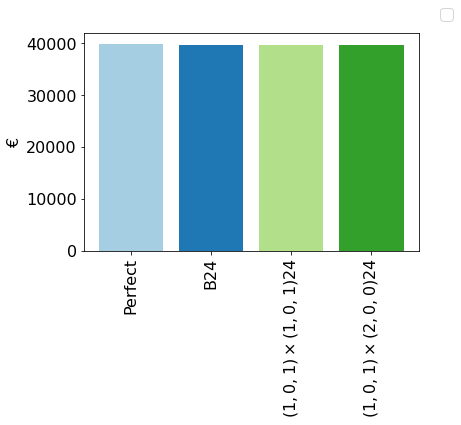

In [38]:
fig, ax = plt.subplots()
legend = create_normal_bar_chart(ax, consumer_plot_data_model_comparison, colors=colors)
get_min_max_costs(consumer_plot_data_model_comparison)

fig.legend(legend)


In [39]:
scenario_diff_plot_data = plot_data_model_comparison
scenario_diff_plot_data[ENERDAG_WITH_10kWh_SIMPLE] = plot_data_prosumers[ENERDAG_WITH_10kWh_SIMPLE]
scenario_comp_diff = create_diff_data(scenario_diff_plot_data, ENERDAG_WITH_10kWh_SIMPLE)


Max: $(1,0,1)\times (2,0,0)24$: -675.53
Min: Perfect: -1474.99


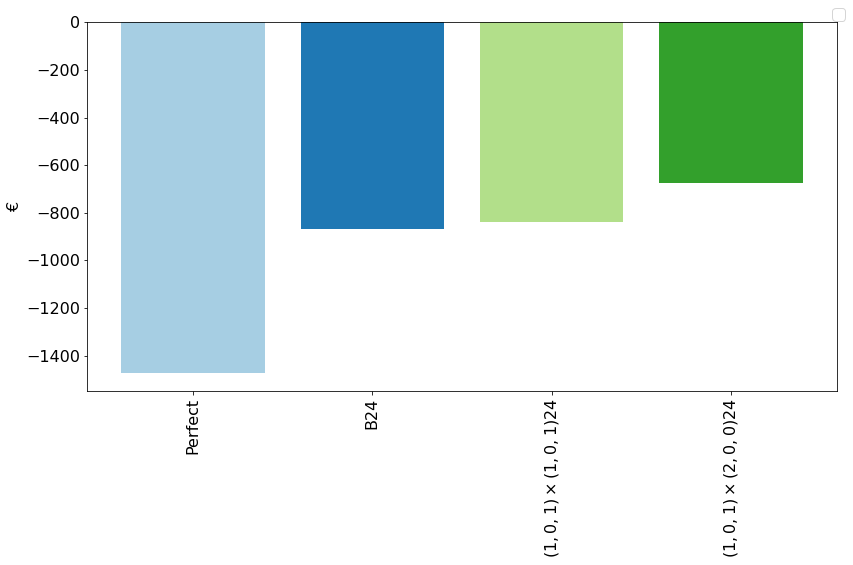

In [40]:
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(12,8))
legend = create_normal_bar_chart(ax, scenario_comp_diff, colors=colors)
# print_costs(plot_data_model_comparison)
get_min_max_costs(scenario_comp_diff)

fig.legend(legend);
fig.tight_layout()
fig.savefig(PurePath(figure_folder, "economic_comparisons_smart_simple_battery.png"))


In [41]:
alternate_prices = PriceSpec(
            Money.from_cents(6),
            Money.from_cents(30),
            cost_of_generation=Money.from_cents(6),
            cost_of_storage=Money.from_cents(10),
            enerdag_net_costs=Money.from_cents(0),
            avg_p2p_trade=Money.from_cents(19),)
plot_data_consumers_alternate_prices = {
     #"Kein PV":  cal_buy_cost_for_consumers(simulation_costs["NoBattery"], alternate_prices), 
    "Ohne enerDAG": calc_pv_wo_enerdag_consumers(simulation_dataframes["NoBattery"], alternate_prices), 
    "PV + Batterie ": calc_pv_and_batter_wo_enerdag_consumers(simulation_dataframes["SimpleBattery (10 kWh)"], alternate_prices), 
    "enerDAG ohne Batterie": calc_enerdag_total_cost_consumers(simulation_dataframes["NoBattery"], alternate_prices),
    "enerDAG SimpleBattery": calc_enerdag_total_cost_consumers(simulation_dataframes["SimpleBattery (10 kWh)"], alternate_prices), 
    "enerDAG SmartBattery": calc_enerdag_total_cost_consumers(simulation_dataframes["SarimaSmartBattery (10 kWh)"], alternate_prices), 
}

KeyError: 'NoBattery'

In [ ]:
fig, ax = plt.subplots()
legend = create_stacked_barchart(ax, plot_data_consumers_alternate_prices, colors=colors)
get_min_max_costs(plot_data_consumers_alternate_prices)

fig.legend(legend)
